# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.4 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%%time
vars = pd.read_csv('/content/sample_data/vars_final6.csv')
print(vars.shape)
vars.head()

(96397, 22)
CPU times: user 235 ms, sys: 33 ms, total: 268 ms
Wall time: 268 ms


,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3,...,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_7,Card_Merchdesc_max_30,card_zip3_avg_1,card_zip_avg_0,card_zip_avg_1,Card_Merchdesc_avg_0,card_zip3_avg_0,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,7.24,3.62,3.62,1,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,7.24,3.62,10.86,7.24,7.24,1,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5,0


In [ ]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])

final_vars_list

['Recnum',
 'Fraud',
 'card_merch_total_14',
 'card_zip3_max_30',
 'card_zip3_total_1',
 'Card_Merchnum_desc_avg_30',
 'Merchnum_total_0',
 'card_zip3_total_0',
 'card_zip_total_0',
 'amount_cat',
 'Card_Merchnum_desc_max_30',
 'Card_Merchnum_desc_med_3']

In [ ]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,7.24,3.62,3.62,1,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,10.86,7.24,7.24,1,3.62,3.62


In [ ]:
vars.shape

(96397, 12)

In [ ]:
vars['Fraud'].sum()

1059

In [ ]:
vars.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,7.24,3.62,3.62,1,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,10.86,7.24,7.24,1,3.62,3.62
5,6,0,3.67,3.67,3.67,3.67,14.53,3.67,3.67,1,3.67,3.67
6,7,0,3.62,3.62,3.62,3.62,18.15,3.62,3.62,1,3.62,3.62
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,4,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,2,62.11,62.11
9,10,0,10.86,3.62,10.86,3.62,21.77,10.86,10.86,1,3.62,3.62


In [ ]:
vars.shape

(96397, 12)

In [ ]:
vars.describe()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,769.967286,591.548408,620.760453,403.854551,777.305666,538.442185,531.796481,2.999222,508.229074,394.856685
std,27945.003883,0.104236,4168.214517,1136.743057,4027.918233,784.922248,2842.302519,2626.535168,2623.087903,1.414452,1065.683344,792.543172
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1.000000,0.010000,0.010000
25%,24154.000000,0.000000,77.000000,69.450000,53.130000,42.536667,89.850000,48.000000,47.330000,2.000000,47.990000,35.940000
50%,48365.000000,0.000000,236.920000,255.850000,179.000000,165.000000,273.460000,164.490000,160.940000,3.000000,199.000000,144.000000
75%,72578.000000,0.000000,676.860000,717.810000,538.240000,462.650000,762.990000,500.000000,495.900000,4.000000,585.000000,435.000000
max,96753.000000,1.000000,306633.410000,47900.000000,306633.410000,28392.840000,217467.180000,217467.180000,217467.180000,5.000000,47900.000000,28392.840000


In [ ]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [ ]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,769.967286,591.548408,620.760453,403.854551,777.305666,538.442185,531.796481,2.999222,508.229074,394.856685
std,4168.214517,1136.743057,4027.918233,784.922248,2842.302519,2626.535168,2623.087903,1.414452,1065.683344,792.543172
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1.000000,0.010000,0.010000
25%,77.000000,69.450000,53.130000,42.536667,89.850000,48.000000,47.330000,2.000000,47.990000,35.940000
50%,236.920000,255.850000,179.000000,165.000000,273.460000,164.490000,160.940000,3.000000,199.000000,144.000000
75%,676.860000,717.810000,538.240000,462.650000,762.990000,500.000000,495.900000,4.000000,585.000000,435.000000
max,306633.410000,47900.000000,306633.410000,28392.840000,217467.180000,217467.180000,217467.180000,5.000000,47900.000000,28392.840000


In [ ]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [ ]:
# use this to cap variables. For some problems it helps
Clip = 10

In [ ]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,2.034397e-17,-1.769041e-18,4.127763e-18,8.049137e-17,3.891890e-17,-6.515968e-17,6.486484e-18,-7.842749e-17,3.891890e-17,5.395575e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847211e-01,-5.203800e-01,-1.541120e-01,-5.145026e-01,-2.734739e-01,-2.049971e-01,-2.027330e-01,-1.413425e+00,-4.768950e-01,-4.982021e-01
25%,-1.662504e-01,-4.592932e-01,-1.409240e-01,-4.603232e-01,-2.418658e-01,-1.867259e-01,-1.846932e-01,-7.064377e-01,-4.318723e-01,-4.528670e-01
50%,-1.278838e-01,-2.953160e-01,-1.096746e-01,-3.043035e-01,-1.772667e-01,-1.423747e-01,-1.413816e-01,5.500594e-04,-2.901698e-01,-3.165212e-01
75%,-2.233745e-02,1.110731e-01,-2.048712e-02,7.490608e-02,-5.036644e-03,-1.463608e-02,-1.368482e-02,7.075378e-01,7.203915e-02,5.065127e-02
max,7.337997e+01,4.161754e+01,7.597291e+01,3.565829e+01,7.623744e+01,8.259122e+01,8.270229e+01,1.414525e+00,4.447078e+01,3.532676e+01


In [ ]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=84300
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [ ]:
alphas = 10**np.linspace(2,9,30)*0.5

In [ ]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [ ]:
ridge = Ridge()
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_trn,Y_trn.values.ravel())
    coefs.append(ridge.coef_)
np.shape(coefs)

(30, 10)

CPU times: user 853 ms, sys: 57.2 ms, total: 910 ms
Wall time: 1.22 s


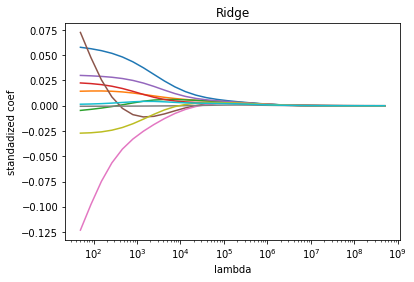

In [ ]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standadized coef')
plt.title('Ridge')
plt.savefig('ridge.png')

In [ ]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [ ]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_trn,Y_trn.values.ravel())
    coefs.append(lasso.coef_)
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
CPU times: user 45.1 s, sys: 5.6 s, total: 50.7 s
Wall time: 28.5 s


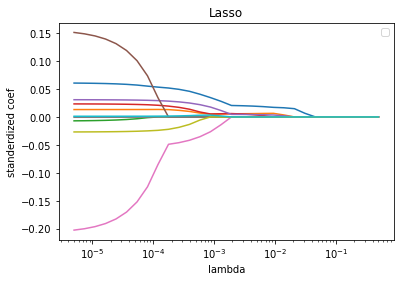

In [ ]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef')
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [ ]:
len(X_trntst.columns)

10

In [ ]:
X_trntst_save = X_trntst.copy()

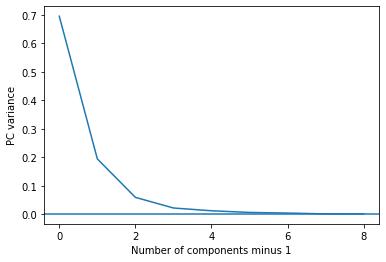

In [ ]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [ ]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.159966,1.006598,0.900941,-0.165039,-0.109360,-0.017543
1,-1.006327,0.683792,0.294090,-0.077584,-0.097126,-0.016956
2,-0.634340,0.222994,-0.218626,-0.023950,-0.094092,-0.021207
3,-1.159524,1.006882,0.900824,-0.165548,-0.108507,-0.016993
4,-1.157468,1.008329,0.900402,-0.166152,-0.108369,-0.017273


In [ ]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
84300,-0.269239,-0.002944,0.063354,0.714442,0.431246,-0.477195
84301,-0.889013,0.690106,0.316287,-0.041639,-0.061503,-0.099121
84302,2.972977,-2.508192,-0.009607,-0.360184,-0.208650,-0.093140
84303,-0.594962,0.198108,-0.201649,-0.030049,-0.095751,-0.022080
84304,0.409335,-0.815806,-1.154290,-0.019748,0.011175,0.035436


In [ ]:
X_trntst.describe()

,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3
count,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000
mean,0.002823,0.002981,0.002267,0.002619,0.005723,0.002123,0.002015,-0.005262,0.003469,0.003208
std,1.056878,1.010112,1.058437,0.995601,1.053107,1.054994,1.055014,1.006408,1.015946,0.999042
min,-0.184721,-0.520380,-0.154112,-0.514503,-0.273474,-0.204997,-0.202733,-1.413425,-0.476895,-0.498202
25%,-0.166298,-0.461673,-0.141205,-0.463396,-0.241508,-0.187084,-0.185140,-0.706438,-0.434152,-0.455012
50%,-0.127630,-0.297251,-0.109980,-0.304335,-0.176053,-0.142988,-0.141746,0.000550,-0.291108,-0.315947
75%,-0.022098,0.116925,-0.020788,0.078216,-0.001690,-0.014636,-0.014028,0.707538,0.074854,0.054030
max,73.379967,41.617542,75.972905,35.658290,76.237442,82.591218,82.702293,1.414525,44.470781,35.326761


In [ ]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.064852,-0.013861,-0.049174,0.015961,-0.015091,-0.016392
std,1.779781,1.186233,0.796215,0.454989,0.285859,0.224043
min,-1.166575,-31.642339,-2.431551,-10.968611,-3.298450,-7.696354
25%,-0.927003,-0.372869,-0.651768,-0.110685,-0.100178,-0.036597
50%,-0.569049,0.254892,-0.206863,-0.022677,-0.088694,-0.018811
75%,0.174762,0.668081,0.331304,0.045671,-0.012465,0.000133
max,58.842513,7.581790,19.864872,13.005540,9.419834,4.088609


In [ ]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [ ]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04
mean,-3.961508e-18,1.011449e-17,1.652033e-17,1.011449e-18,-1.095736e-17,2.697197e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.292865e-01,-2.294864e+01,-1.587878e+01,-2.153926e+01,-2.655433e+01,-2.956449e+01
25%,-3.522998e-01,-2.709621e-01,-8.068528e-01,-3.170686e-01,-2.711981e-01,-1.262065e-01
50%,-2.141526e-01,1.779870e-01,-2.303999e-01,-6.143743e-02,-2.372208e-01,-6.688869e-02
75%,8.071360e-02,4.766800e-01,5.939839e-01,8.690096e-02,6.721818e-03,6.125312e-02
max,5.925765e+01,5.399097e+01,3.137247e+01,4.612804e+01,4.269319e+01,3.752655e+01


In [ ]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.023865,-0.009639,-0.061667,0.032634,-0.040979,-0.060355
std,0.654940,0.824882,0.998510,0.930260,0.776250,0.824941
min,-0.429286,-22.003438,-3.049335,-22.426150,-8.956931,-28.338404
25%,-0.341127,-0.259286,-0.817363,-0.226303,-0.272034,-0.134751
50%,-0.209404,0.177247,-0.259420,-0.046364,-0.240848,-0.069265
75%,0.064310,0.464570,0.415478,0.093378,-0.033848,0.000491
max,21.653390,5.272222,24.911939,26.590804,25.579529,15.054484


In [ ]:
X_trntst_pca.shape

(84300, 6)

In [ ]:
X_oot_orig_pca.shape

(12097, 6)

## Subsample the larger class if desired

In [ ]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.01043890865954923
(1751, 10) 1751


In [ ]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [ ]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [ ]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20) #solver = 'liblinear', l1_ratio = 0.4)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0 0.6505823627287853 0.6379928315412187 0.33519553072625696
1 0.6382306477093207 0.6396761133603239 0.2905027932960894


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 0.6508196721311476 0.6296296296296297 0.3016759776536313


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 0.6330128205128205 0.67578125 0.2905027932960894
4 0.653160453808752 0.6615969581749049 0.329608938547486
trn    0.645161
tst    0.648935
oot    0.309497
dtype: float64
CPU times: user 1.16 s, sys: 770 ms, total: 1.93 s
Wall time: 1.06 s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=10,min_samples_split= 40,min_samples_leaf=20)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.779050736497545 0.7286245353159851 0.2346368715083799
1 0.8431372549019608 0.7574626865671642 0.22905027932960895
2 0.8148148148148148 0.7451737451737451 0.27932960893854747
3 0.7840531561461794 0.7302158273381295 0.4301675977653631
4 0.785 0.7642857142857142 0.41899441340782123
trn    0.801211
tst    0.745153
oot    0.318436
dtype: float64
CPU times: user 3.35 s, sys: 53.9 ms, total: 3.4 s
Wall time: 3.33 s


In [ ]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=10,max_depth=5,min_samples_split=50,min_samples_leaf=30,max_features=3)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.7367549668874173 0.7681159420289855 0.553072625698324
1 0.7383333333333333 0.7107142857142857 0.5586592178770949
2 0.7508532423208191 0.6938775510204082 0.3743016759776536
3 0.740495867768595 0.76 0.553072625698324
4 0.7659574468085106 0.6691449814126395 0.5586592178770949
trn    0.746479
tst    0.720371
oot    0.519553
dtype: float64
CPU times: user 4.77 s, sys: 0 ns, total: 4.77 s
Wall time: 4.83 s


In [ ]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(n_estimators=100, max_depth = 3, num_leaves=4, col_sample_bytree = 0.8, learning_rate = 0.03, eval_metric = 'auc')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.7739837398373983 0.7773584905660378 0.4972067039106145
1 0.8054662379421221 0.7635658914728682 0.5139664804469274
2 0.7903494176372712 0.7491039426523297 0.4972067039106145
3 0.803125 0.7333333333333333 0.5083798882681564
4 0.7765273311897106 0.7596899224806202 0.45251396648044695
trn    0.789890
tst    0.756610
oot    0.493855
dtype: float64
CPU times: user 5.57 s, sys: 0 ns, total: 5.57 s
Wall time: 3.02 s


In [ ]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=20,activation = 'relu', alpha = 0.0001, learning_rate = 'adaptive', solver = 'lbfgs', learning_rate_init = 0.0001 )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0 0.7617504051863857 0.7756653992395437 0.5363128491620112


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1 0.7692307692307693 0.73046875 0.4692737430167598


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


2 0.7725040916530278 0.7620817843866171 0.4581005586592179


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3 0.7504051863857374 0.779467680608365 0.5195530726256983
4 0.7678571428571429 0.7310606060606061 0.4972067039106145
trn    0.764350
tst    0.755749
oot    0.496089
dtype: float64
CPU times: user 57 s, sys: 30.5 s, total: 1min 27s
Wall time: 50.6 s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(2))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=5,n_estimators=10, min_samples_leaf = 1, subsample = 1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.8117088607594937 0.7137096774193549 0.29608938547486036
1 0.8413461538461539 0.76953125 0.43575418994413406
2 0.7895569620253164 0.7379032258064516 0.4134078212290503
3 0.7996820349761526 0.7649402390438247 0.25139664804469275
4 0.85062893081761 0.7254098360655737 0.4134078212290503
trn    0.818585
tst    0.742299
oot    0.362011
dtype: float64
CPU times: user 15.5 s, sys: 63.8 ms, total: 15.5 s
Wall time: 16.5 s


In [ ]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=16, iterations=15, random_state=10, bootstrap_type = 'Bayesian')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.8157894736842105 0.7426470588235294 0.5083798882681564
1 0.7921440261865794 0.7657992565055762 0.4972067039106145
2 0.7937806873977087 0.7434944237918215 0.5083798882681564
3 0.7902439024390244 0.7584905660377359 0.5083798882681564
4 0.7911908646003263 0.7640449438202247 0.5195530726256983
trn    0.796630
tst    0.754895
oot    0.508380
dtype: float64
CPU times: user 3min 32s, sys: 3min 6s, total: 6min 38s
Wall time: 4min 21s


In [ ]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set.
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

#     model.fit(X_trn, Y_trn.values.ravel())

#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # unsupervised model using pc's.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=5, n_estimators=25, tree_method= 'auto', subsample = 0.8)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.7951612903225806 0.7576923076923077 0.4972067039106145
1 0.7903494176372712 0.7419354838709677 0.45251396648044695
2 0.8006535947712419 0.7723880597014925 0.441340782122905
3 0.78330658105939 0.77431906614786 0.4860335195530726
4 0.7919354838709678 0.7769230769230769 0.43575418994413406
trn    0.792281
tst    0.764652
oot    0.462570
dtype: float64
CPU times: user 9.7 s, sys: 36.5 ms, total: 9.73 s
Wall time: 9.72 s


In [ ]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1,
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [ ]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.650582,0.637993,0.335196
1,log reg,0.638231,0.639676,0.290503
2,log reg,0.65082,0.62963,0.301676
3,log reg,0.633013,0.675781,0.290503
4,log reg,0.65316,0.661597,0.329609
5,DT,0.779051,0.728625,0.234637
6,DT,0.843137,0.757463,0.22905
7,DT,0.814815,0.745174,0.27933
8,DT,0.784053,0.730216,0.430168
9,DT,0.785,0.764286,0.418994


In [ ]:
df.shape

(40, 4)

In [ ]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.650582
1,log reg,Trn,0.638231
2,log reg,Trn,0.65082
3,log reg,Trn,0.633013
4,log reg,Trn,0.65316


In [ ]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.650582
1,log reg,Trn,0.638231
2,log reg,Trn,0.65082
3,log reg,Trn,0.633013
4,log reg,Trn,0.65316


In [ ]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.801211  0.027346  0.745153  0.015921  0.318436  0.098916
GBC        0.818585  0.026420  0.742299  0.024373  0.362011  0.082617
LGBM       0.789890  0.014574  0.756610  0.016481  0.493855  0.024223
NN         0.764350  0.008715  0.755749  0.023706  0.496089  0.032909
RF         0.746479  0.012199  0.720371  0.042630  0.519553  0.081246
XGB        0.792281  0.006379  0.764652  0.014734  0.462570  0.027482
cat boost  0.796630  0.010790  0.754895  0.011130  0.508380  0.007901
log reg    0.645161  0.008958  0.648935  0.019100  0.309497  0.021492

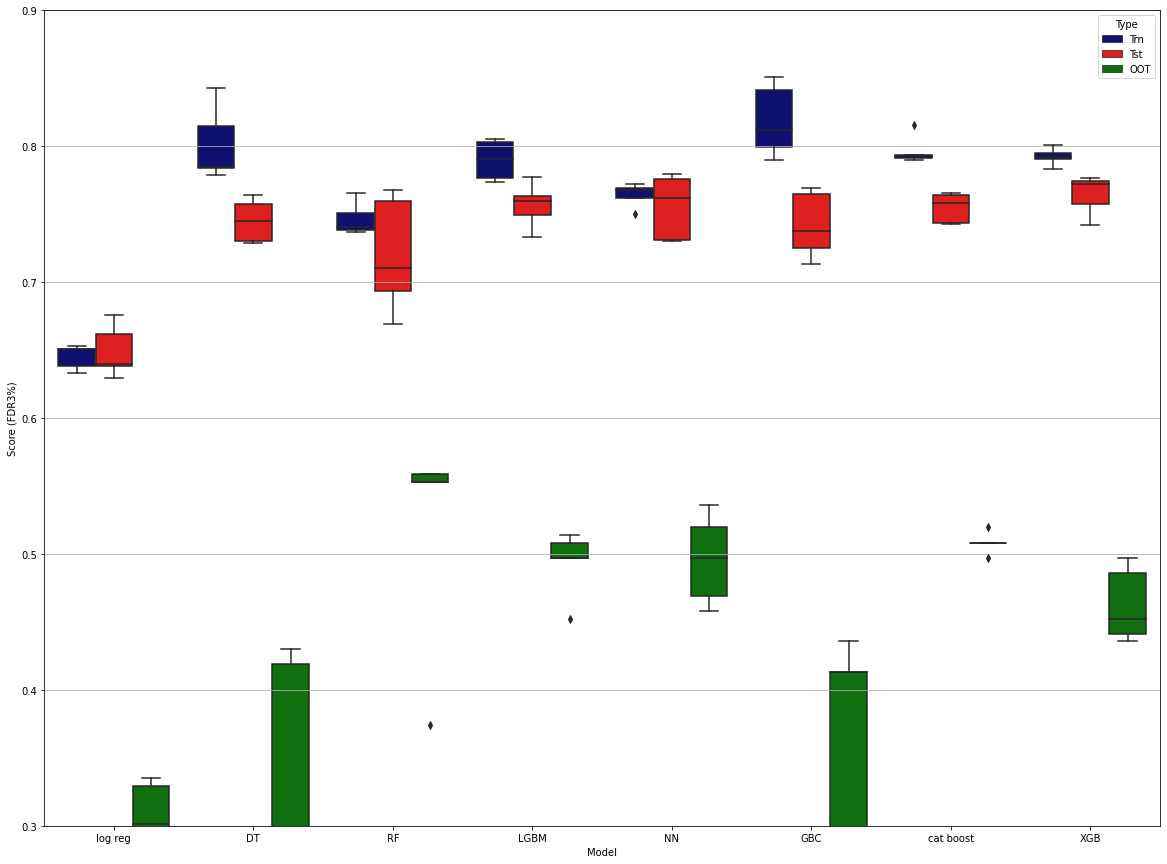

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.3,.9)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

duration:  0:07:08.553735


[LightGBM] [Warning] Unknown parameter: eval_metric
0 0.6638935108153078 0.6594982078853047 0.40782122905027934
[LightGBM] [Warning] Unknown parameter: eval_metric
1 0.6600660066006601 0.6934306569343066 0.36312849162011174
[LightGBM] [Warning] Unknown parameter: eval_metric
2 0.6727574750830565 0.6618705035971223 0.36312849162011174
[LightGBM] [Warning] Unknown parameter: eval_metric
3 0.6678141135972461 0.6688963210702341 0.3743016759776536
[LightGBM] [Warning] Unknown parameter: eval_metric
4 0.6661237785016286 0.7142857142857143 0.4022346368715084
loop trn tst oot 1 0.6661309769195798 0.6795962807545364 0.38212290502793295
[LightGBM] [Warning] Unknown parameter: eval_metric
0 0.8496 0.7843137254901961 0.48044692737430167
[LightGBM] [Warning] Unknown parameter: eval_metric
1 0.8282504012841091 0.8249027237354085 0.5139664804469274
[LightGBM] [Warning] Unknown parameter: eval_metric
2 0.8543046357615894 0.7934782608695652 0.5363128491620112
[LightGBM] [Warning] Unknown parameter: eva

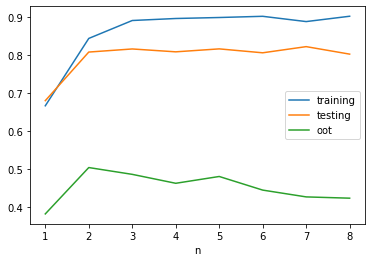

In [ ]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in np.arange(1,16,2):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = lgb.LGBMClassifier(n_estimators=1000, max_depth = i, num_leaves=10, learning_rate = 0.01, eval_metric = 'logloss')

        model.fit(X_trn, Y_trn.values.ravel())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True)
table.plot()
#plt.savefig('complexity_YOUR MODEL NAME.pdf', format='pdf')
plt.show()

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [ ]:
%%time

for niter in range(30):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=16, iterations=15, random_state=10, bootstrap_type = 'Bayesian')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.8037676609105181 0.7654320987654321 0.4581005586592179
1 0.8152350081037277 0.7604562737642585 0.4860335195530726
2 0.7961165048543689 0.7442748091603053 0.5251396648044693
3 0.8166666666666667 0.7821428571428571 0.5251396648044693
4 0.7940199335548173 0.7446043165467626 0.5139664804469274
trn    0.805161
tst    0.759382
oot    0.501676
dtype: float64
CPU times: user 3min 29s, sys: 2min 52s, total: 6min 22s
Wall time: 4min 3s


In [ ]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [ ]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,card_zip3_max_30,card_zip3_total_1,Card_Merchnum_desc_avg_30,Merchnum_total_0,card_zip3_total_0,card_zip_total_0,amount_cat,Card_Merchnum_desc_max_30,Card_Merchnum_desc_med_3,predicted,Fraud
89068,4.294732,2.664042,4.481364,1.310688,6.295609,6.903729,6.915336,1.414525,2.919864,0.980683,0.969154,1
89074,5.006737,2.664042,5.218169,1.473671,7.339759,8.033655,8.046747,1.414525,2.919864,1.007905,0.969154,1
89057,3.313470,2.664042,3.465924,1.137306,4.856596,5.346503,5.356063,1.414525,2.919864,0.980683,0.962995,1
89077,5.249519,2.664042,5.469408,1.372480,7.695797,8.418942,8.432540,0.707538,2.919864,0.980683,0.961210,1
89060,3.537990,2.664042,3.698265,1.091352,5.185853,5.702809,5.712837,1.414525,2.919864,0.882309,0.951058,1
89055,2.954419,2.664042,3.094368,1.105448,4.330051,4.776703,4.785514,1.414525,2.919864,0.882309,0.951058,1
89114,6.341771,2.664042,6.599704,1.231915,1.328301,1.528362,1.532905,1.414525,2.919864,0.882309,0.933617,1
89128,7.032132,2.664042,7.314111,1.065932,2.340709,2.623939,2.629921,0.707538,2.919864,0.733270,0.920477,1
89130,9.112811,6.778209,9.467263,1.494006,5.392010,5.925901,5.936223,1.414525,7.308363,0.783936,0.916471,1
89183,9.722223,6.778209,10.097901,1.443541,6.285708,6.893016,6.904608,1.414525,7.308363,0.783936,0.916471,1


In [ ]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot

    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,72.0,49.0,59.504132,40.495868,121.0,72.0,49.0,0.604128,27.374302,26.770173,1.469388
2,2.0,121.0,96.0,25.0,79.338843,20.661157,242.0,168.0,74.0,1.409632,41.340782,39.931150,2.270270
3,3.0,121.0,103.0,18.0,85.123967,14.876033,363.0,271.0,92.0,2.273871,51.396648,49.122777,2.945652
4,4.0,121.0,117.0,4.0,96.694215,3.305785,484.0,388.0,96.0,3.255580,53.631285,50.375705,4.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,121.0,121.0,0.0,100.000000,0.000000,11613.0,11434.0,179.0,95.938916,100.000000,4.061084,63.877095
97,97.0,121.0,121.0,0.0,100.000000,0.000000,11734.0,11555.0,179.0,96.954187,100.000000,3.045813,64.553073
98,98.0,121.0,121.0,0.0,100.000000,0.000000,11855.0,11676.0,179.0,97.969458,100.000000,2.030542,65.229050
99,99.0,121.0,121.0,0.0,100.000000,0.000000,11976.0,11797.0,179.0,98.984729,100.000000,1.015271,65.905028


In [ ]:
FDR3.to_csv('FDR3.csv')

In [ ]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [ ]:
print("duration: ", datetime.now() - start_time)

duration:  0:10:56.226993


Max possible savings: 18,828,000.0


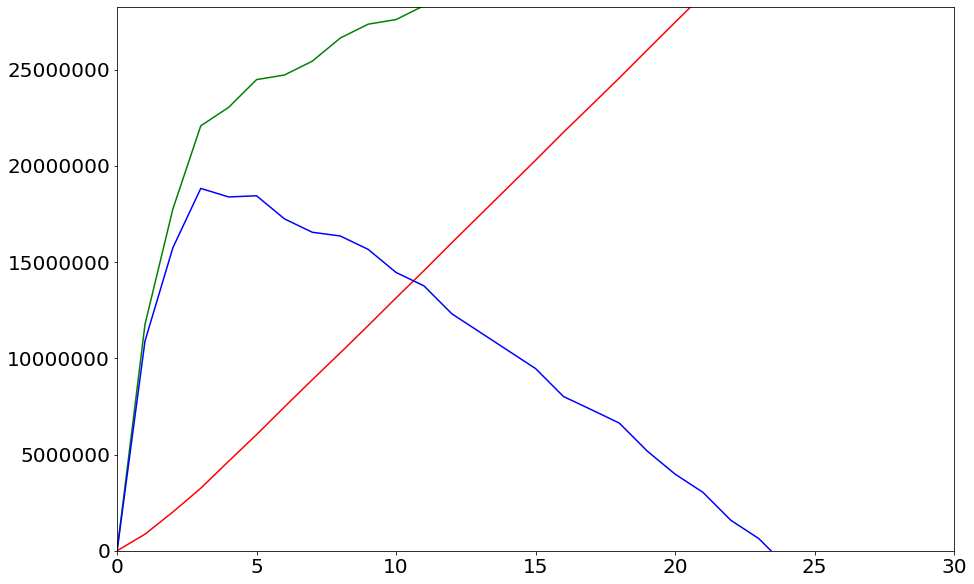

In [ ]:
import pandas as pd
import numpy as np

cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
  Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
  Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
  Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')